Connected to venv (Python 3.13.5)

In [1]:
import sys

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian

from utils import set_global_seed
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

# The cell below requires editing the parameter being varied

In [ ]:
# Define and fix seed
SEED: int = 20
set_global_seed(SEED)

# Specify the parameter to be varied and it's symbol
VARYING_PARAM: str = "damping"
VARYING_PARAM_NOTATION: str = "d"

# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Specify the range of parameter values
PARAM_LIST: list[float] = [0.0015, 0.015, 0.15, 1.5]
# DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])

In [42]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

CMAP: str = "seismic"  # Color map for the visualisations

# Move tensors and models to GPU
DEVICE: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float64
).to(device=DEVICE)

# Boolean constant for whether or not PI controllers included
CONTROLLERS: bool = False

# PINN Hyperparameter constants
LEARNING_RATE: float = 1.0
# SCHEDULER_STEP_SIZE: int = 200
PATIENCE: int = 50
SCHEDULER_FACTOR: float = 0.9
HISTORY: int = 100
EPOCHS: int = 200
N_C: int = 5_000  # Number of collocation points

# PINN soft regularisation weights in the loss function
PHYSICS_WEIGHT: float = 1.0
IC_WEIGHT: float = 1.0

# Specify activation function
ACTIVATION: str = "tanh"

# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
collocation_points = LHC.random(n=N_C)
collocation_points = qmc.scale(
    collocation_points, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

collocation_points: torch.tensor = torch.tensor(
    data=collocation_points[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)

## Obtain a numerical solution to obtain an array of indices to index on

In [4]:
_, _, times = swing_ODEs_solver(
initial_time=0,
initial_state=INITIAL_STATE.detach().numpy(),
final_time=20.0,
timestep=0.1,
sigma=np.array([0.02, 0.02]),
inertia=0.1,
damping=PARAM_LIST[0],
mechanical_power=0.13,
voltage_magnitude=1.0,
include_controllers=False,
voltages=np.array([1.0]),
phase_angles=np.array([0.0]),
susceptances=np.array([0.2]),
file_name="test_run",
save_output_to_file=False,
controller_proportional=0.05,
controller_integral=0.1,
)

# Obtain a random array of index to index the numerical solution on to obtain training data
rand_index = np.random.randint(low=1, high=len(times)-1, size=149)
rand_index = np.append(rand_index, 0)    

In [5]:
# Define subspace mesh
alpha_1: torch.Tensor = torch.arange(start=-1, end=1.05, step=0.05)
alpha_2: torch.Tensor = torch.arange(start=-1, end=1.05, step=0.05)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION).to(device=DEVICE)).total_params

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vectors
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into unit vector
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-8
assert torch.norm(input=direction_vec_1) - 1 < 1e-8
assert torch.norm(input=direction_vec_2) - 1 < 1e-8

# Train the PINNs and obtain the Hessian-based and random direction subspaces
## The cell below requires editing the parameter being varied

In [43]:
loss_landscapes_random = []
loss_landscapes_hessian = []
pinn_models = []
training_losses = []

for index, param in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Obtain numerical solution
    solution, _, times = swing_ODEs_solver(
    initial_time=0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=20.0,
    timestep=0.1,
    sigma=np.array([0.02, 0.02]),
    inertia=0.1,
    damping=param,
    mechanical_power=0.13,
    voltage_magnitude=1.0,
    include_controllers=False,
    voltages=np.array([1.0]),
    phase_angles=np.array([0.0]),
    susceptances=np.array([0.2]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1,
    )

    times = np.array([times[id] for id in rand_index]).flatten()
    times = torch.tensor(
        data=times.astype(np.float32)[:, None], requires_grad=True
    ).to(device=DEVICE)

    training_data = np.array([solution[0,:][id] for id in rand_index]).flatten()
    training_data = torch.tensor(
        data=training_data.astype(np.float32)[:, None]
    ).to(device=DEVICE)

    # Define PINN, optimiser and learning rate scheduler
    pinn = PINN(activation=ACTIVATION).to(device=DEVICE)

    optimiser = torch.optim.LBFGS(
        params=pinn.parameters(),
        lr=LEARNING_RATE,
        history_size=HISTORY,
        line_search_fn="strong_wolfe",
    )

    # lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    # )

    # Define array to collect training loss every epoch
    training_loss = []

    for epoch in tqdm(range(EPOCHS)):
        
        # Backpropogate using reverse/backward-mode AD
        def closure():
            optimiser.zero_grad()

            phase_angle_pred = pinn.forward(data=collocation_points, initial_state=INITIAL_STATE)

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss = loss_func(inputs=None, targets=None)
            loss.backward()
            return loss
            
        loss = optimiser.step(closure=closure)
        # lr_scheduler.step(metrics=loss)

        training_loss.append(loss.item())

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")

    
    pinn_models.append(pinn)
    training_losses.append(training_loss)

    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters())

    # Obtain the eigenvectors of the Hessian matrix of the loss function
    phase_angle_pred = pinn.forward(
        data=collocation_points, initial_state=INITIAL_STATE
    )

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    angular_acceleration_pred = torch.autograd.grad(
        outputs=angular_frequency_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(angular_frequency_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    swing_inputs = SwingEquationInputs(
        phase_angle=phase_angle_pred,
        angular_frequency=angular_frequency_pred,
        angular_acceleration=angular_acceleration_pred,
        inertia=INERTIA,
        damping=DAMPING,
        mechanical_power=MECHANICAL_POWER,
        voltage_magnitude=VOLTAGE,
        voltages=VOLTAGES,
        phase_angles=PHASE_ANGLES,
        susceptances=SUSCEPTANCES,
        controller_proportional=None,
        controller_integral=None,
    )

    loss_func = loss_closure(
        swing_inputs=swing_inputs,
        physics_weight=PHYSICS_WEIGHT,
        IC_weight=IC_WEIGHT,
        model=pinn,
        initial_state=INITIAL_STATE,
        device=DEVICE,
        include_controllers=CONTROLLERS,
    )
    
    hessian_comp = hessian(pinn, loss_func, data=(times, training_data), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Define lists to collect the loss landscapes for both random and eigenvector directions
    loss_landscape = []
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + i * direction_vec_1 + j * direction_vec_2

            vector_to_parameters(vec=perturbation, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb = loss_func(inputs=None, targets=None)
            loss_landscape.append(loss_perturb.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

            # Repeat for Hessian eigenvectors
            perturbation_hessian = MINIMISER + i * first_eigenvector + j * second_eigenvector

            vector_to_parameters(vec=perturbation_hessian, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb = loss_func(inputs=None, targets=None)
            loss_landscape_hessian.append(loss_perturb.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape = np.array(loss_landscape).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])

    loss_landscapes_random.append(loss_landscape)
    loss_landscapes_hessian.append(loss_landscape_hessian)

Param value 1
----------------------



  0%|          | 1/200 [00:00<00:56,  3.50it/s]

Training loss: 0.08976910597160498


 56%|█████▌    | 112/200 [00:06<00:01, 74.98it/s]

Training loss: 9.469428996625062e-05


100%|██████████| 200/200 [00:07<00:00, 27.60it/s]


Param value 2
----------------------



  0%|          | 1/200 [00:00<00:50,  3.94it/s]

Training loss: 0.309767494745454


 57%|█████▋    | 114/200 [00:05<00:01, 76.81it/s]

Training loss: 9.073313046669584e-05


100%|██████████| 200/200 [00:06<00:00, 29.20it/s]


Param value 3
----------------------



  0%|          | 1/200 [00:00<00:53,  3.69it/s]

Training loss: 0.2395065759003143


 55%|█████▌    | 110/200 [00:04<00:01, 76.85it/s]

Training loss: 3.585843589242188e-06


100%|██████████| 200/200 [00:06<00:00, 32.69it/s]


Param value 4
----------------------



  0%|          | 1/200 [00:00<00:56,  3.54it/s]

Training loss: 0.1210979146872833


 56%|█████▌    | 111/200 [00:02<00:01, 79.61it/s]

Training loss: 3.442561302624543e-07


100%|██████████| 200/200 [00:03<00:00, 60.97it/s]


## Plot the loss landscapes and contour plots for the PINNs

/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


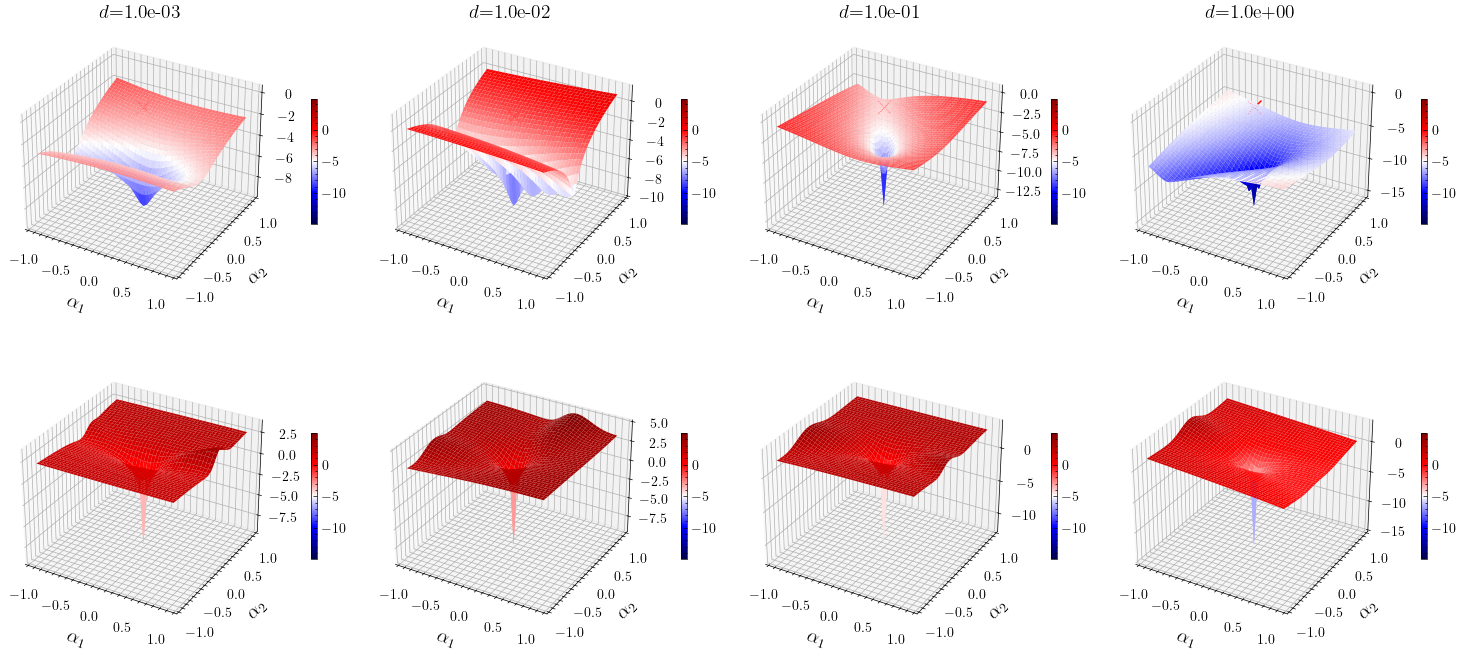

In [44]:
all_losses = np.array([ls.flatten() for ls in [*loss_landscapes_random, *loss_landscapes_hessian]]).flatten()
log_losses = [np.log(loss) for loss in all_losses]
vmin = np.min([np.min(log_loss) for log_loss in log_losses])
vmax = np.max([np.max(log_loss) for log_loss in log_losses])

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    surf = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[index]),
        cmap=CMAP,
        vmin=vmin,
        vmax=vmax,
        linewidth=0,
        antialiased=True,
        zorder=1
    )

    ax[0, idx].scatter(xs=0, ys=0, color='red', s=100, marker='x', zorder=10)
    
    fig.colorbar(surf, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    surf = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[index]),
        cmap=CMAP,
        vmin=vmin,
        vmax=vmax,
        linewidth=0,
        antialiased=True
        # alpha=0.7
    )

    fig.colorbar(surf, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

# loss_landscape_image_name = f"{VARYING_PARAM}_loss_landscape_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

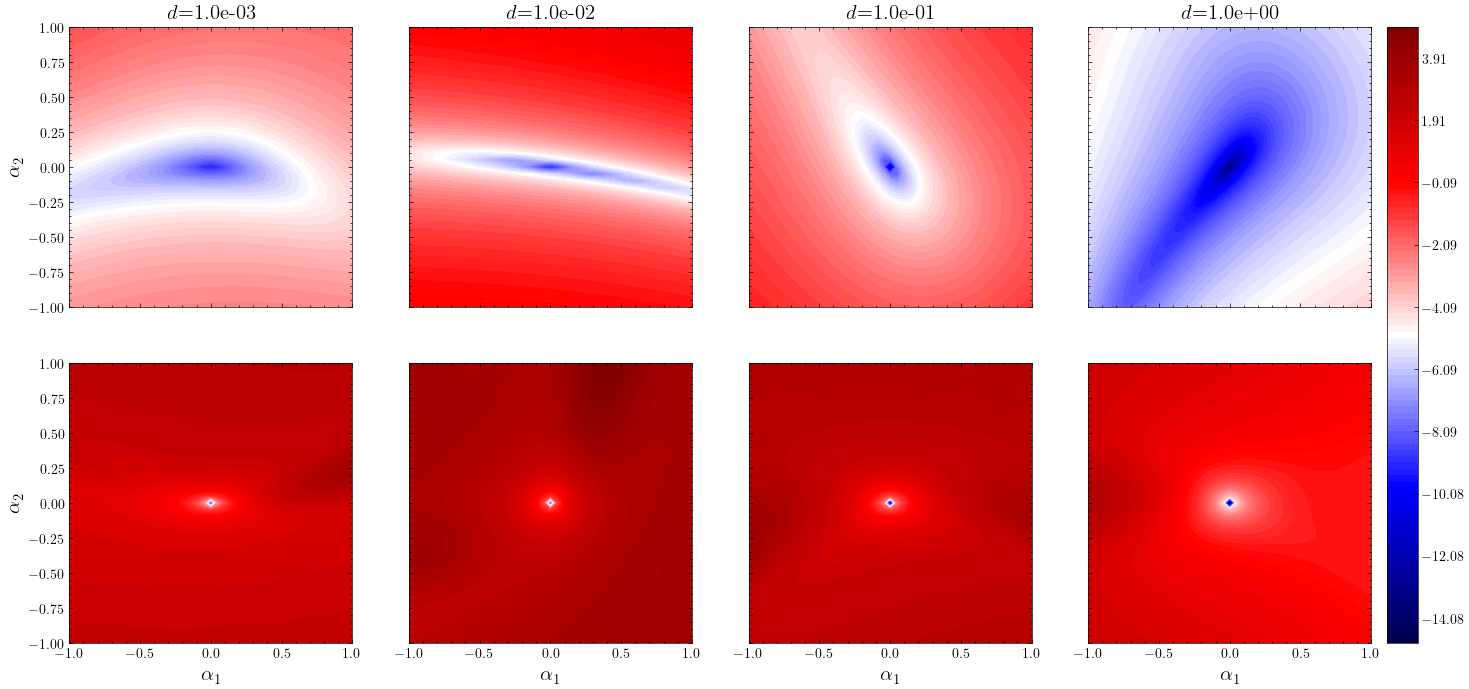

In [45]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
levels = np.linspace(vmin, vmax, num_levels)

contours_pinn = []

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour = ax[0, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[index]),
        cmap=CMAP,
        levels=levels,
        vmax=vmax,
        vmin=vmin
    )
    contours_pinn.append(contour)
    
    if index == 0:
        ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=15)


for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour = ax[1, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=levels,
        vmax=vmax,
        vmin=vmin
    )
    contours_pinn.append(contour)
    
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15)

    if index == 0:
        ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

# Shared colorbar
cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)
# plt.savefig(...)
plt.show()

## Plot the PINN vs RK45 solution
## The cell below requires editing the parameter being varied

<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_4076/1118450122.py:54: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_4076/1118450122.py:55: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


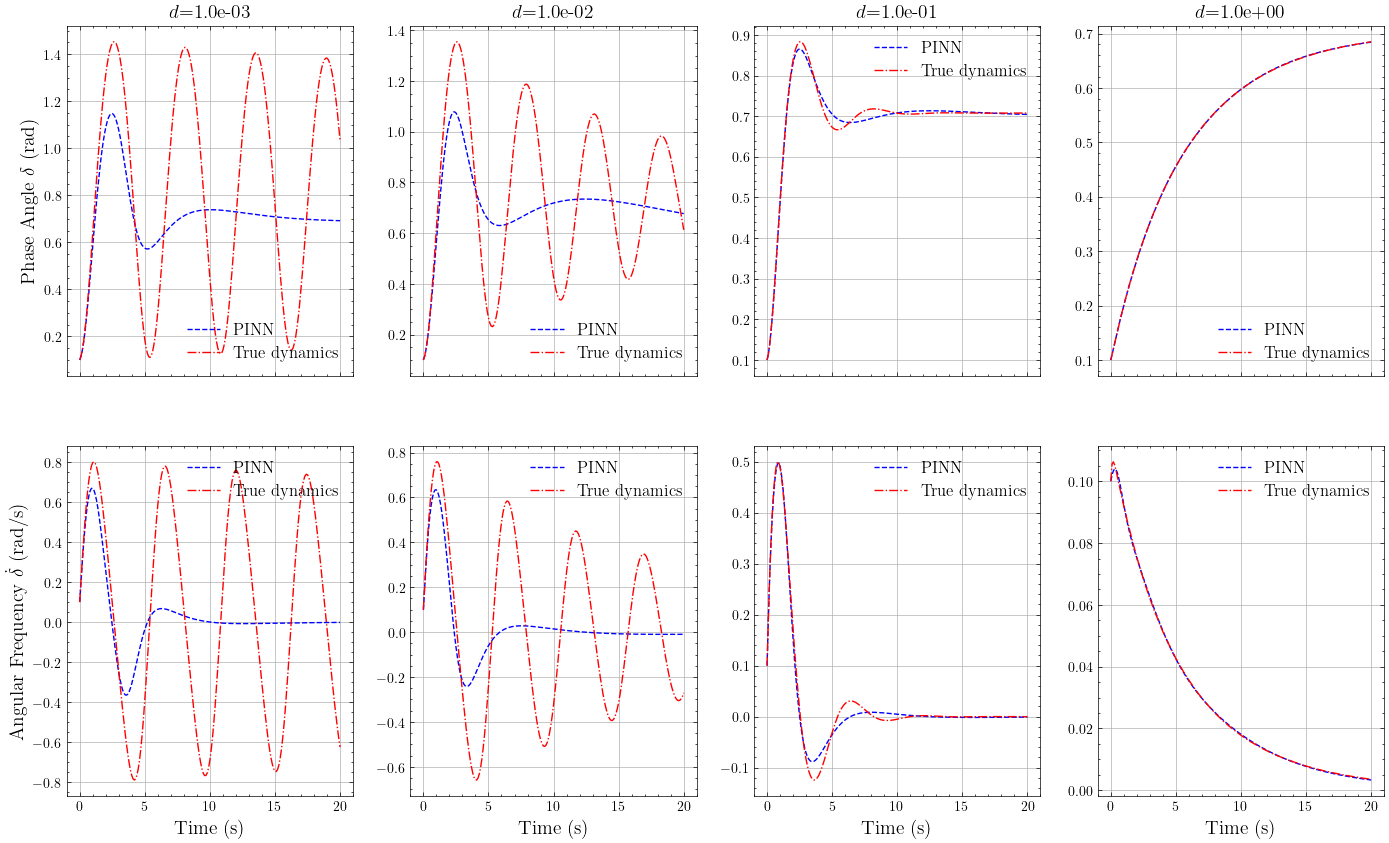

In [46]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    solution, _, times = swing_ODEs_solver(
        initial_time=0,
        initial_state=INITIAL_STATE.detach().numpy(),
        final_time=20.0,
        timestep=0.1,
        sigma=np.array([0.02, 0.02]),
        inertia=0.1,
        damping=param,
        mechanical_power=0.13,
        voltage_magnitude=1.0,
        include_controllers=False,
        voltages=np.array([1.0]),
        phase_angles=np.array([0.0]),
        susceptances=np.array([0.2]),
        file_name="test_run",
        save_output_to_file=False,
        controller_proportional=0.05,
        controller_integral=0.1,
    )

    times = torch.tensor(
        data=times.astype(np.float32)[:,None], requires_grad=True
    ).to(device=DEVICE)


    phase_angle_pred = pinn_models[index].forward(data=times, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=times,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]


    ax[0, index].plot(times.detach().numpy(), phase_angle_pred.detach().numpy(), color='blue', linestyle='--', label='PINN')
    ax[0, index].plot(times.detach().numpy(), solution[0, :], color="red", linestyle="-.", label="True dynamics")
    ax[0, index].grid()
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    ax[1, index].plot(times.detach().numpy(), angular_frequency_pred.detach().numpy(), color='blue', linestyle='--', label='PINN')
    ax[1, index].plot(times.detach().numpy(), solution[1, :], color="red", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

exact_vs_pred_image: str = f"{VARYING_PARAM}_pinn_vs_ground_truth_seed_{SEED}.pdf"

# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()
# plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")
plt.show()

# Train the vanilla NN

In [47]:
vanilla_nn_hessian_loss_landscapes = []
vanilla_nn_loss_landscapes = []

vanilla_nns = []

vanilla_training_losses = []

for index, param in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    solution, _, times = swing_ODEs_solver(
        initial_time=0,
        initial_state=INITIAL_STATE.detach().numpy(),
        final_time=20.0,
        timestep=0.1,
        sigma=np.array([0.02, 0.02]),
        inertia=0.1,
        damping=param,
        mechanical_power=0.13,
        voltage_magnitude=1.0,
        include_controllers=False,
        voltages=np.array([1.0]),
        phase_angles=np.array([0.0]),
        susceptances=np.array([0.2]),
        file_name="test_run",
        save_output_to_file=False,
        controller_proportional=0.05,
        controller_integral=0.1,
    )

    times = np.array([times[id] for id in rand_index]).flatten()
    times = torch.tensor(
        data=times.astype(np.float32)[:, None], requires_grad=True
    ).to(device=DEVICE)

    training_data = np.array([solution[0,:][id] for id in rand_index]).flatten()
    training_data = torch.tensor(
        data=training_data.astype(np.float32)[:, None]
    ).to(device=DEVICE)

    # Define PINN, optimiser and learning rate scheduler
    nn = PINN(activation=ACTIVATION).to(device=DEVICE)

    # optimiser = torch.optim.Adam(params=nn.parameters(), lr=LEARNING_RATE)

    # lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    # )

    optimiser = torch.optim.LBFGS(
    params=nn.parameters(),
    lr=LEARNING_RATE,
    history_size=HISTORY,   
    line_search_fn="strong_wolfe",
    )

    MSE_loss = torch.nn.MSELoss()

    # Define array to collect training loss every epoch
    training_loss = []

    for epoch in tqdm(range(EPOCHS)):

        # Backpropogate using reverse/backward-mode AD
        def closure():
            optimiser.zero_grad()

            # Obtain PINN predictions and it's time derivatives
            phase_angle_pred = nn.forward(data=times, initial_state=INITIAL_STATE)

            # Obtain the loss
            loss = MSE_loss(phase_angle_pred, training_data)
            loss.backward()
            return loss
            
        loss = optimiser.step(closure=closure)

        training_loss.append(loss.item())

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")

    vanilla_nns.append(nn)
    vanilla_training_losses.append(training_loss)

    hessian_comp = hessian(nn, MSE_loss, data=(times, training_data), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    MINIMISER = parameters_to_vector(nn.parameters())

    loss_landscape = []
    loss_landscape_hessian = []

    nn.eval()

    for i in alpha_1:
        for j in alpha_2:
            perturbation = MINIMISER + i * direction_vec_1 + j * direction_vec_2
            perturbation_hessian = MINIMISER + i * first_eigenvector + j * second_eigenvector

            vector_to_parameters(vec=perturbation, parameters=nn.parameters())

            phase_angle_pred = nn.forward(
                data=times, initial_state=INITIAL_STATE
            )

            loss_perturb = MSE_loss(phase_angle_pred, training_data)

            loss_landscape.append(loss_perturb.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())

            # Repeat for Hessian eigenvectors
            vector_to_parameters(vec=perturbation_hessian, parameters=nn.parameters())

            phase_angle_pred = nn.forward(
                data=times, initial_state=INITIAL_STATE
            )

            loss_perturb_hessian = MSE_loss(phase_angle_pred, training_data)

            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())

    loss_landscape = np.array(loss_landscape).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])

    vanilla_nn_loss_landscapes.append(loss_landscape)
    vanilla_nn_hessian_loss_landscapes.append(loss_landscape_hessian)

Param value 1
----------------------



  4%|▎         | 7/200 [00:00<00:03, 59.54it/s]

Training loss: 0.42964375019073486


 86%|████████▌ | 172/200 [00:01<00:00, 278.78it/s]

Training loss: 0.02717023901641369


100%|██████████| 200/200 [00:01<00:00, 156.45it/s]


Param value 2
----------------------



  4%|▎         | 7/200 [00:00<00:02, 67.08it/s]

Training loss: 0.5162268877029419


 80%|████████  | 160/200 [00:01<00:00, 228.36it/s]

Training loss: 4.581750545185059e-05


100%|██████████| 200/200 [00:01<00:00, 128.22it/s]


Param value 3
----------------------



  4%|▎         | 7/200 [00:00<00:02, 66.28it/s]

Training loss: 0.1391964703798294


100%|██████████| 200/200 [00:00<00:00, 601.37it/s]


Training loss: 9.976990440918598e-06
Param value 4
----------------------



100%|██████████| 200/200 [00:00<00:00, 1510.15it/s]

Training loss: 0.47701406478881836
Training loss: 7.025097374935285e-07


## Plot the training loss against epochs for the PINNs and vanilla NNs

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_4076/1709823135.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$ (log scale)", fontsize=12)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_4076/1709823135.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)


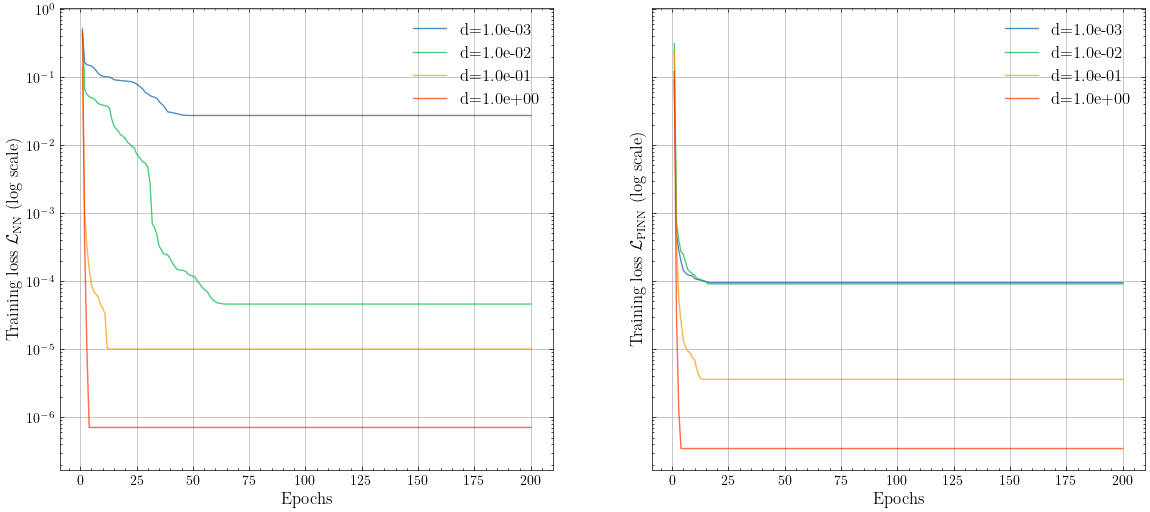

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for (param, training_loss) in zip(PARAM_LIST, vanilla_training_losses):
    ax[0].semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax[0].set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$ (log scale)", fontsize=12)
ax[0].set_xlabel("Epochs", fontsize=12)
ax[0].grid()
ax[0].legend(loc="best", fontsize=12)

for (param, training_loss) in zip(PARAM_LIST, training_losses):
    ax[1].semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax[1].set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)
ax[1].set_xlabel("Epochs", fontsize=12)
ax[1].grid()
ax[1].legend(loc="best", fontsize=12)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+training_losses_plot, format="pdf", bbox_inches="tight")

plt.show()

## Plot the loss landscapes and contour plots for the vanilla NNs

/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


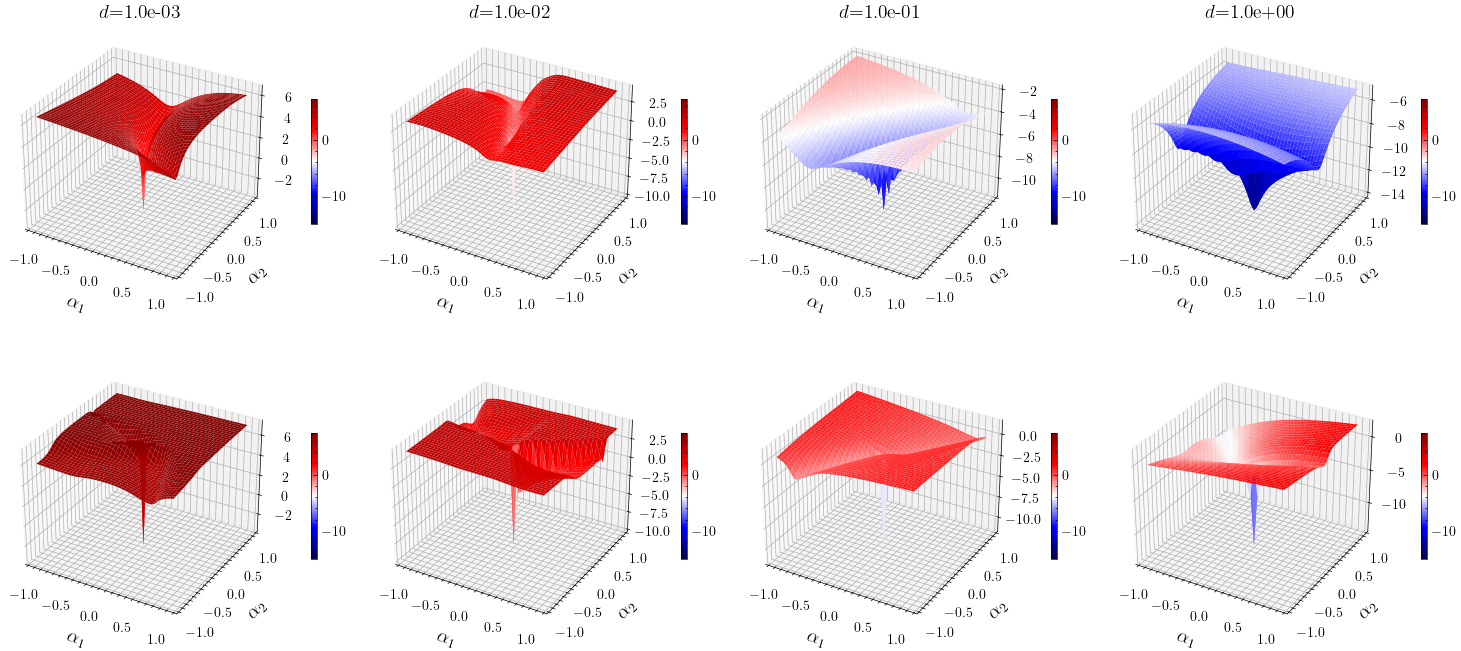

-14.88187989190737
7.265429979345485


In [49]:
all_losses = np.array([ls.flatten() for ls in [*vanilla_nn_loss_landscapes, *vanilla_nn_hessian_loss_landscapes, *loss_landscapes_random, *loss_landscapes_hessian]]).flatten()
log_losses = [np.log(loss) for loss in all_losses]
vmin = np.min([np.min(log_loss) for log_loss in log_losses])
vmax = np.max([np.max(log_loss) for log_loss in log_losses])

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    surf = ax[0, idx].plot_surface(
        ALPHA_1, ALPHA_2, np.log(vanilla_nn_loss_landscapes[index]), cmap=CMAP, vmin=vmin, vmax=vmax, linewidth=0, antialiased=True
    )
    fig.colorbar(surf, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    surf = ax[1, idx].plot_surface(
        ALPHA_1, ALPHA_2, np.log(vanilla_nn_hessian_loss_landscapes[index]), cmap=CMAP, vmin=vmin, vmax=vmax, linewidth=0, antialiased=True
    )
    fig.colorbar(surf, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

# loss_landscape_image_name = f"{VARYING_PARAM}_loss_landscape_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()
print(vmin)
print(vmax)

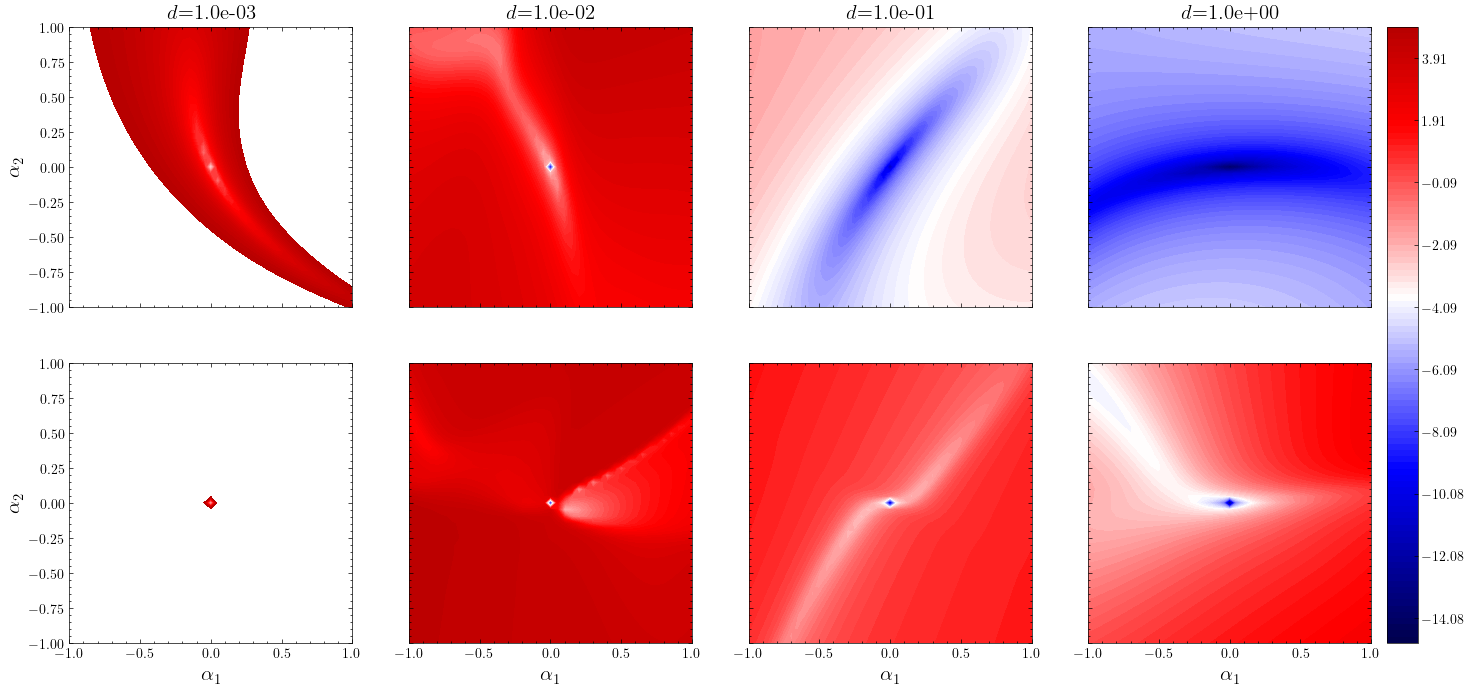

In [50]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

contours_vanilla = []

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour = ax[0, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(vanilla_nn_loss_landscapes[index]),
        cmap=CMAP,
        levels=levels,
        vmax=vmax,
        vmin=vmin
    )
    contours_vanilla.append(contour)
    
    if index == 0:
        ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=15)


for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour = ax[1, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(vanilla_nn_hessian_loss_landscapes[index]),
        cmap=CMAP,
        levels=levels,
        vmax=vmax,
        vmin=vmin
    )
    contours_vanilla.append(contour)
    
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15)

    if index == 0:
        ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

# Shared colorbar
cbar = fig.colorbar(contours_vanilla[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)
# plt.savefig(...)
plt.show()

<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_4076/2183076592.py:54: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_4076/2183076592.py:55: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


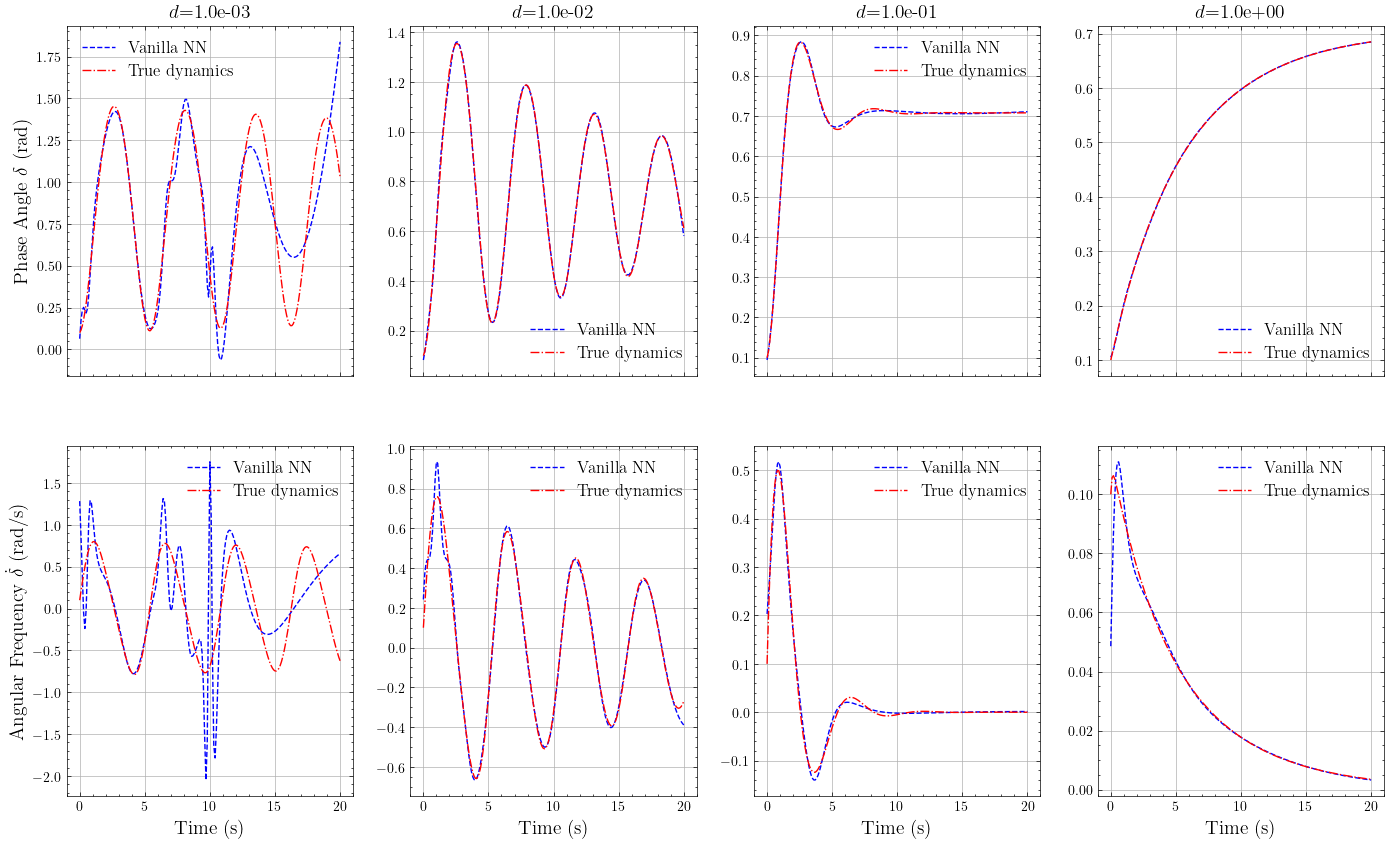

In [51]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    solution, _, times = swing_ODEs_solver(
        initial_time=0,
        initial_state=INITIAL_STATE.detach().numpy(),
        final_time=20.0,
        timestep=0.1,
        sigma=np.array([0.02, 0.02]),
        inertia=0.1,
        damping=param,
        mechanical_power=0.13,
        voltage_magnitude=1.0,
        include_controllers=False,
        voltages=np.array([1.0]),
        phase_angles=np.array([0.0]),
        susceptances=np.array([0.2]),
        file_name="test_run",
        save_output_to_file=False,
        controller_proportional=0.05,
        controller_integral=0.1,
    )

    times = torch.tensor(
        data=times.astype(np.float32)[:,None], requires_grad=True
    ).to(device=DEVICE)


    phase_angle_pred = vanilla_nns[index].forward(data=times, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=times,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]


    ax[0, index].plot(times.detach().numpy(), phase_angle_pred.detach().numpy(), color='blue', linestyle='--', label='Vanilla NN')
    ax[0, index].plot(times.detach().numpy(), solution[0, :], color="red", linestyle="-.", label="True dynamics")
    ax[0, index].grid()
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    ax[1, index].plot(times.detach().numpy(), angular_frequency_pred.detach().numpy(), color='blue', linestyle='--', label='Vanilla NN')
    ax[1, index].plot(times.detach().numpy(), solution[1, :], color="red", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

# exact_vs_pred_image: str = f"{VARYING_PARAM}_pinn_vs_ground_truth_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")
plt.show()